In [1]:
from HeaderP import *
import tqdm

In [2]:
df = pd.read_pickle('APOGEE_DR17_loggCorrect_rb.pkl')
df = df.loc[df['[Mg/Fe]_err']<0.02].reset_index(drop=True)
len(df)

43759

In [3]:
df_inner = df.loc[df['Rb']<6].reset_index(drop=True)
df_lowalpha = df.loc[(abs(df['[Mg/Fe]']-0.05)<0.05)].reset_index(drop=True)


0.06052631578947365


Text(0, 0.5, '[Mg/Fe]')

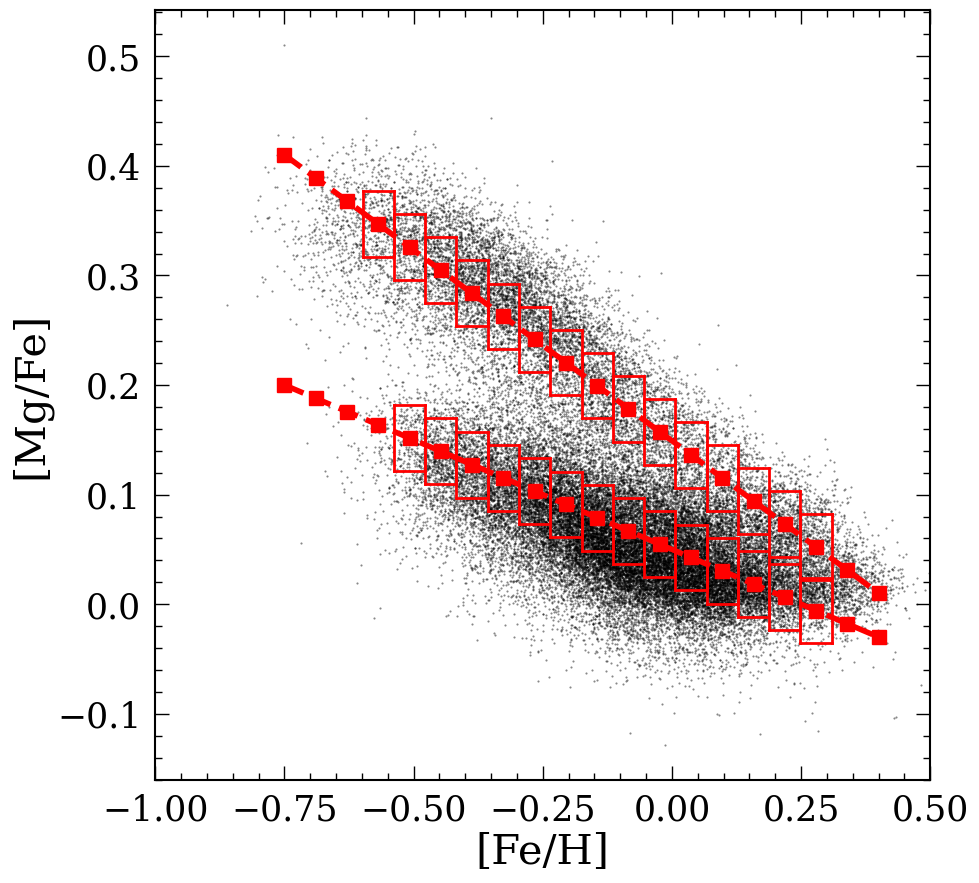

In [4]:
numbselect = 200

plt.plot(df['[Fe/H]'], df['[Mg/Fe]'], 'k.', markersize=1, alpha=0.5)
#plt.plot(df_inner['[Fe/H]'], df_inner['[Mg/Fe]'], 'r.', markersize=1)
#plt.plot(df_lowalpha['[Fe/H]'], df_lowalpha['[Mg/Fe]'], 'b.', markersize=1)

mgfe_boxsize = 0.03
mgfe_out = [0.2,-0.03]

plt.plot([-0.75,0.4],[0.41,0.01], 'r--', linewidth=4, zorder=10)
p_inner = fitpoints([-0.75,0.4],[0.41,0.01])
plt.plot([-0.75,0.4],[mgfe_out[0],mgfe_out[1]], 'r--', linewidth=4, zorder=10)
p_lowalpha = fitpoints([-0.75,0.4],[mgfe_out[0],mgfe_out[1]])

# draw some bins
fehbins = np.linspace(-0.75,0.4,20)
#fehbins = fehbins[2:]
print(np.diff(fehbins)[0])

dfeh = np.diff(fehbins)[0]/2

plt.plot(fehbins, p_lowalpha(fehbins), 'rs', markersize=10)
plt.plot(fehbins, p_inner(fehbins), 'rs', markersize=10)


for i in range(len(fehbins)-2):
    df_inner_feh = df.loc[(df['[Fe/H]']>fehbins[i]-dfeh)&(df['[Fe/H]']<fehbins[i]+dfeh)]
    df_lowalpha_feh = df.loc[(df['[Fe/H]']>fehbins[i]-dfeh)&(df['[Fe/H]']<fehbins[i]+dfeh)]

    df_inner_feh_2 = df.loc[(df['[Fe/H]']>fehbins[i+1]-dfeh)&(df['[Fe/H]']<fehbins[i+1]+dfeh)]
    df_lowalpha_feh_2 = df.loc[(df['[Fe/H]']>fehbins[i+1]-dfeh)&(df['[Fe/H]']<fehbins[i+1]+dfeh)]

    # inner box compare
    inner_firstbox = df_inner_feh.loc[(df_inner_feh['[Mg/Fe]']>p_inner(fehbins[i])-mgfe_boxsize)&(df_inner_feh['[Mg/Fe]']<p_inner(fehbins[i])+mgfe_boxsize)]
    inner_secbox = df_inner_feh_2.loc[(df_inner_feh_2['[Mg/Fe]']>p_inner(fehbins[i+1])-mgfe_boxsize)&(df_inner_feh_2['[Mg/Fe]']<p_inner(fehbins[i+1])+mgfe_boxsize)]

    # outer box compare
    outer_firstbox = df_lowalpha_feh.loc[(df_lowalpha_feh['[Mg/Fe]']>p_lowalpha(fehbins[i])-mgfe_boxsize)&(df_lowalpha_feh['[Mg/Fe]']<p_lowalpha(fehbins[i])+mgfe_boxsize)]
    outer_secbox = df_lowalpha_feh_2.loc[(df_lowalpha_feh_2['[Mg/Fe]']>p_lowalpha(fehbins[i+1])-mgfe_boxsize)&(df_lowalpha_feh_2['[Mg/Fe]']<p_lowalpha(fehbins[i+1])+mgfe_boxsize)]

    """print('feh',fehbins[i])
    print(len(inner_firstbox), len(inner_secbox))
    print(len(outer_firstbox), len(outer_secbox))"""
    
    if (len(inner_firstbox)>=numbselect)&(len(inner_secbox)>=numbselect):
        plt.plot([fehbins[i]-dfeh, fehbins[i]+dfeh], 
            [p_inner(fehbins[i])-mgfe_boxsize, p_inner(fehbins[i])-mgfe_boxsize],'r-',
            linewidth=2)
        plt.plot([fehbins[i]-dfeh, fehbins[i]+dfeh], 
                [p_inner(fehbins[i])+mgfe_boxsize, p_inner(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]-dfeh, fehbins[i]-dfeh], 
                [p_inner(fehbins[i])-mgfe_boxsize, p_inner(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]+dfeh, fehbins[i]+dfeh], 
                [p_inner(fehbins[i])-mgfe_boxsize, p_inner(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
    
    if (len(outer_firstbox)>=numbselect)&(len(outer_secbox)>=numbselect):
        plt.plot([fehbins[i]-dfeh, fehbins[i]+dfeh], 
                [p_lowalpha(fehbins[i])-mgfe_boxsize, p_lowalpha(fehbins[i])-mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]-dfeh, fehbins[i]+dfeh], 
                [p_lowalpha(fehbins[i])+mgfe_boxsize, p_lowalpha(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]-dfeh, fehbins[i]-dfeh], 
                [p_lowalpha(fehbins[i])-mgfe_boxsize, p_lowalpha(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]+dfeh, fehbins[i]+dfeh], 
                [p_lowalpha(fehbins[i])-mgfe_boxsize, p_lowalpha(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)




plt.xlim([-1,0.5])
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')

In [5]:
from astropy.stats import bootstrap

def samples(abun, abun_err, xs, xs_err,n,fehs_val,delta_feh):
    
    samples_abun = np.zeros((len(abun),n))
    samples_xs = np.zeros((len(abun),n))
    samples_median = np.zeros((n))
    n_samples = len(abun)
    
    # create the bootstrap samples  
    # in order to sample the distribution using bootstrap with resampling and to get the correct
    # information for every star picked, we need to sample an id array, and use that to pick out the sampled stars
    # otherwise you get incorrect fehs for every abundance
    random_ids = np.arange(len(abun))
    samples_indices = bootstrap(random_ids, n).astype(int)
      
    for indx3, k in enumerate(samples_indices):
        # find the stars with the correct id
        mask_feh = (xs[k] < delta_feh+fehs_val)&(xs[k] > fehs_val-delta_feh)
        samples_median[indx3] = np.nanmedian(abun[k][mask_feh])
    return samples_median

def find_mean_scatter_norm(abundances, abundances_err,xs,xs_err,fehs_val = -1,delta_feh=0.05,n=1000):


    abundances_list = ['[O/Fe]','[Mg/Fe]','[Si/Fe]','[S/Fe]','[Ca/Fe]','[Ti/Fe]','[C/Fe]',\
                       '[N/Fe]','[Al/Fe]','[K/Fe]','[Mn/Fe]','[Ni/Fe]','[Ce/Fe]']
    
    xfe_mean = np.zeros((len(abundances)))
    xfe_scatter = np.zeros((len(abundances)))
    xfe_meanerr = np.zeros((len(abundances)))
    samples_median = np.zeros((len(abundances),n))
    for indx, i in enumerate(abundances):
        # make sure you are comparing stars with same logg (already did this when correcting systematics)
        # abundances compared here are between 1 < logg < 2        
        abun = i # abundances in the sample
        xs2 = xs[indx] # feh values in the sample
        abun_err = abundances_err[indx] # errors in the abundances in the sample
        xs2_err = xs_err[indx] # errors in the feh values in the sample

        # draw N samples for every x and y point, fit a line to every N distribution of the x, y plane, and get
        # the mean and sigma values of your slope and intercept
        samples_median_raw = samples(abun, abun_err, xs2, xs2_err,n,fehs_val,delta_feh)
        samples_median[indx] = samples_median_raw
        # determine the mean value of the abundances calculated by taking the mean value of the 1,000 medians
        # also calculate the sigma by taking the standard deviation of the 1,000 medians
        xfe_mean[indx] = np.nanmean(samples_median_raw)
        xfe_scatter[indx] = np.nanstd(samples_median_raw)
        xfe_meanerr[indx] = np.nanstd(samples_median_raw)/np.sqrt(len(samples_median_raw))
    return xfe_mean,xfe_scatter,xfe_meanerr


def getdata(df):
    abun = np.array((df['[O/Fe]'].values,df['[Mg/Fe]'].values,df['[Si/Fe]'].values,df['[S/Fe]'].values,\
                    df['[Ca/Fe]'].values,df['[Ti/Fe]'].values,df['[C/Fe]'].values,df['[N/Fe]'].values,\
                    df['[Al/Fe]'].values,df['[K/Fe]'].values,df['[Mn/Fe]'].values,df['[Ni/Fe]'].values,\
                    df['[Ce/Fe]'].values))
    abun_err = np.array((df['[O/Fe]_err'].values,df['[Mg/Fe]_err'].values,df['[Si/Fe]_err'].values,df['[S/Fe]_err'].values,\
                        df['[Ca/Fe]_err'].values,df['[Ti/Fe]_err'].values,df['[C/Fe]_err'].values,df['[N/Fe]_err'].values,\
                        df['[Al/Fe]_err'].values,df['[K/Fe]_err'].values,df['[Mn/Fe]_err'].values,df['[Ni/Fe]_err'].values,\
                        df['[Ce/Fe]_err'].values))
    feh = np.array((df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,\
                        df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,\
                        df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,\
                        df['[Fe/H]'].values))
    feh_err = np.array((df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,\
                        df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,\
                        df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,\
                        df['[Fe/H]_err'].values))
    
    return abun, abun_err, feh, feh_err

from scipy import stats

abundances_list = ['[O/Fe]','[Mg/Fe]','[Si/Fe]','[S/Fe]','[Ca/Fe]','[Ti/Fe]','[C/Fe]','[N/Fe]','[Al/Fe]','[K/Fe]',\
                   '[Mn/Fe]','[Ni/Fe]','[Ce/Fe]']
def get_chi2(observed_mean,predicted_mean, observed_error, predicted_error):
    from scipy import stats
    
    result = np.zeros((len(observed_mean)))
    for indx, i in enumerate(observed_mean):
        result[indx] = ((i-predicted_mean[indx])**2)/(observed_error[indx]**2+predicted_error[indx]**2)
    chi2 = np.sum((result))
    return chi2

def get_diff(observed_mean,predicted_mean):
    result = np.zeros((len(observed_mean)))
    for indx, i in enumerate(observed_mean):
        result[indx] = ((i-predicted_mean[indx])**2)
    diff = np.sum((result))
    return diff

In [6]:
testtime = 100

allchi2_inn = np.zeros((len(fehbins)-2,testtime))
allchi2_out = np.zeros((len(fehbins)-2,testtime))
diff_inn = np.zeros((len(fehbins)-2,testtime))
diff_out = np.zeros((len(fehbins)-2,testtime))


nbs_inn = np.zeros((len(fehbins)-2,testtime))
nbs_out = np.zeros((len(fehbins)-2,testtime))
rb_inn = np.zeros((len(fehbins)-2,testtime))
rb_out = np.zeros((len(fehbins)-2,testtime))
age_inn = np.zeros((len(fehbins)-2,testtime))
age_out = np.zeros((len(fehbins)-2,testtime))
mgfe_inn = np.zeros((len(fehbins)-2,testtime))
mgfe_out = np.zeros((len(fehbins)-2,testtime))
feh_inn = np.zeros((len(fehbins)-2,testtime))
feh_out = np.zeros((len(fehbins)-2,testtime))



for j in trange(testtime):
    for i in range(len(fehbins)-2):
        df_inner_feh = df.loc[(df['[Fe/H]']>fehbins[i]-dfeh)&(df['[Fe/H]']<fehbins[i]+dfeh)]
        df_lowalpha_feh = df.loc[(df['[Fe/H]']>fehbins[i]-dfeh)&(df['[Fe/H]']<fehbins[i]+dfeh)]

        df_inner_feh_2 = df.loc[(df['[Fe/H]']>fehbins[i+1]-dfeh)&(df['[Fe/H]']<fehbins[i+1]+dfeh)]
        df_lowalpha_feh_2 = df.loc[(df['[Fe/H]']>fehbins[i+1]-dfeh)&(df['[Fe/H]']<fehbins[i+1]+dfeh)]

        # inner box compare
        inner_firstbox = df_inner_feh.loc[(df_inner_feh['[Mg/Fe]']>p_inner(fehbins[i])-mgfe_boxsize)&(df_inner_feh['[Mg/Fe]']<p_inner(fehbins[i])+mgfe_boxsize)]
        inner_secbox = df_inner_feh_2.loc[(df_inner_feh_2['[Mg/Fe]']>p_inner(fehbins[i+1])-mgfe_boxsize)&(df_inner_feh_2['[Mg/Fe]']<p_inner(fehbins[i+1])+mgfe_boxsize)]

        # outer box compare
        outer_firstbox = df_lowalpha_feh.loc[(df_lowalpha_feh['[Mg/Fe]']>p_lowalpha(fehbins[i])-mgfe_boxsize)&(df_lowalpha_feh['[Mg/Fe]']<p_lowalpha(fehbins[i])+mgfe_boxsize)]
        outer_secbox = df_lowalpha_feh_2.loc[(df_lowalpha_feh_2['[Mg/Fe]']>p_lowalpha(fehbins[i+1])-mgfe_boxsize)&(df_lowalpha_feh_2['[Mg/Fe]']<p_lowalpha(fehbins[i+1])+mgfe_boxsize)]


        if (len(inner_firstbox)>=numbselect)&(len(inner_secbox)>=numbselect):
            # abundances for inner box
            inner_firstbox = inner_firstbox.sample(n = numbselect)
            inner_secbox = inner_secbox.sample(n = numbselect)
            abun_inner_firstbox, abun_inner_firstbox_err, feh_inner_firstbox, feh_inner_firstbox_err = getdata(inner_firstbox)
            abun_inner_secbox, abun_inner_secbox_err, feh_inner_secbox, feh_inner_secbox_err = getdata(inner_secbox)

            # calculate for two inner
            xfe_mean_inner_firstbox ,xfe_scatter_inner_firstbox ,xfe_meanerr_inner_firstbox = find_mean_scatter_norm(abun_inner_firstbox, abun_inner_firstbox_err, feh_inner_firstbox, feh_inner_firstbox_err, fehs_val = fehbins[i] )
            xfe_mean_inner_secbox ,xfe_scatter_inner_secbox ,xfe_meanerr_inner_secbox = find_mean_scatter_norm(abun_inner_secbox, abun_inner_secbox_err, feh_inner_secbox, feh_inner_secbox_err, fehs_val = fehbins[i+1] )

            allchi2_inn[i,j] = get_chi2(xfe_mean_inner_firstbox, xfe_mean_inner_secbox, xfe_scatter_inner_firstbox, xfe_scatter_inner_secbox)
            diff_inn[i,j] = get_diff(xfe_mean_inner_firstbox, xfe_mean_inner_secbox)
            nbs_inn[i,j] = min(len(inner_firstbox), len(inner_secbox))
            rb_inn[i,j] = np.mean(inner_firstbox['Rb'])
            age_inn[i,j] = np.mean(inner_firstbox['Age'])
            mgfe_inn[i,j] = np.mean(inner_firstbox['[Mg/Fe]'])
            feh_inn[i,j] = np.mean(inner_firstbox['[Fe/H]'])
            
        else:
            allchi2_inn[i,j] = np.nan
            diff_inn[i,j] = np.nan
            rb_inn[i,j] = np.nan
            age_inn[i,j] = np.nan
            mgfe_inn[i,j] = np.nan
            feh_inn[i,j] = np.nan


        if (len(outer_firstbox)>=numbselect)&(len(outer_secbox)>=numbselect):
            # abundances for outer box
            outer_firstbox = outer_firstbox.sample(n = numbselect)
            outer_secbox = outer_secbox.sample(n = numbselect)
            abun_outer_firstbox, abun_outer_firstbox_err, feh_outer_firstbox, feh_outer_firstbox_err = getdata(outer_firstbox)
            abun_outer_secbox, abun_outer_secbox_err, feh_outer_secbox, feh_outer_secbox_err = getdata(outer_secbox)

            # calculate for two outer
            xfe_mean_outer_firstbox ,xfe_scatter_outer_firstbox ,xfe_meanerr_outer_firstbox = find_mean_scatter_norm(abun_outer_firstbox, abun_outer_firstbox_err, feh_outer_firstbox, feh_outer_firstbox_err, fehs_val = fehbins[i] )
            xfe_mean_outer_secbox ,xfe_scatter_outer_secbox ,xfe_meanerr_outer_secbox = find_mean_scatter_norm(abun_outer_secbox, abun_outer_secbox_err, feh_outer_secbox, feh_outer_secbox_err, fehs_val = fehbins[i+1] )

            allchi2_out[i,j] = get_chi2(xfe_mean_outer_firstbox, xfe_mean_outer_secbox, xfe_scatter_outer_firstbox, xfe_scatter_outer_secbox)
            diff_out[i,j] = get_diff(xfe_mean_outer_firstbox, xfe_mean_outer_secbox)
            nbs_out[i,j] = min(len(outer_firstbox), len(outer_secbox))
            rb_out[i,j] = np.mean(outer_firstbox['Rb'])
            age_out[i,j] = np.mean(outer_firstbox['Age'])
            mgfe_out[i,j] = np.mean(outer_firstbox['[Mg/Fe]'])
            feh_out[i,j] = np.mean(outer_firstbox['[Fe/H]'])
            
        else:
            allchi2_out[i,j] = np.nan
            diff_out[i,j] = np.nan
            rb_out[i,j] = np.nan
            age_out[i,j] = np.nan
            mgfe_out[i,j] = np.nan
            feh_out[i,j] = np.nan
            


    


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [31:35<00:00, 18.96s/it]


"plt.twinx()\nplt.plot(fehbinsmid[:-1], nbs_inn, 'r--')\nplt.plot(fehbinsmid[:-1], nbs_out, 'b--')\nplt.ylabel('# of stars')"

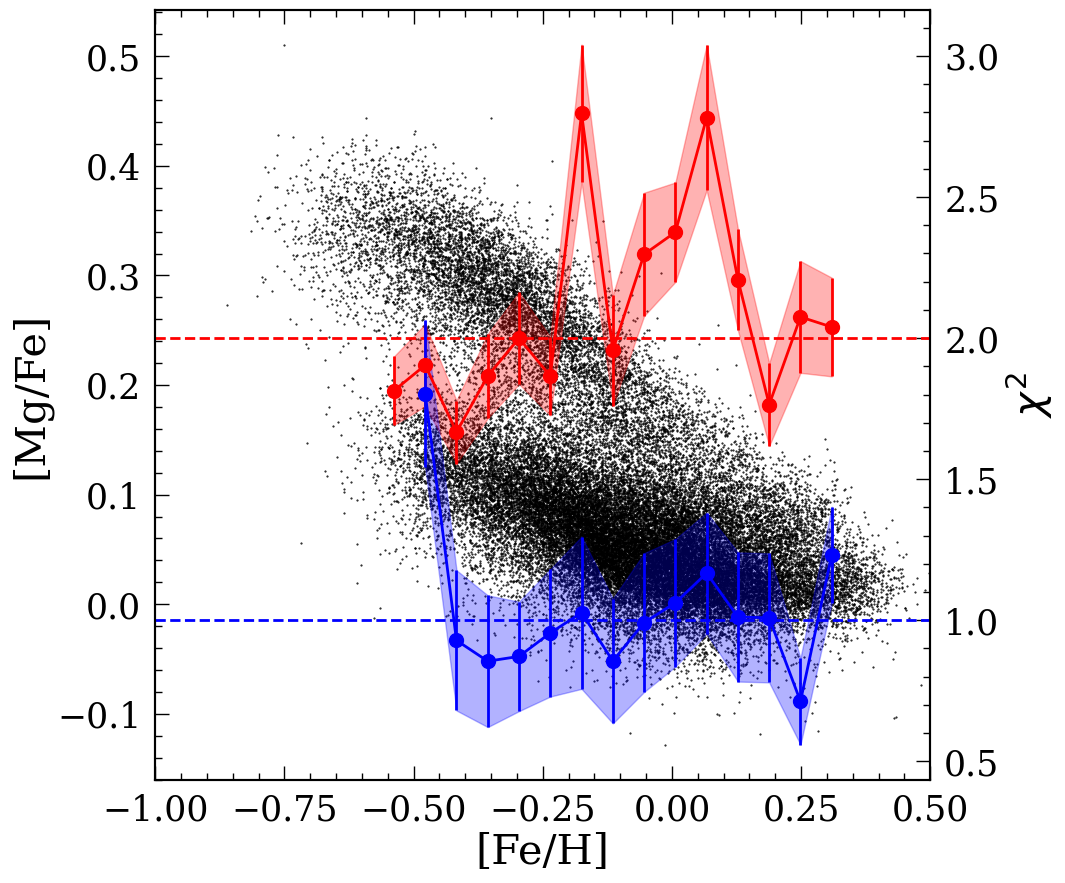

In [10]:
fehbinsmid = (fehbins[:-1]+fehbins[1:])/2

plt.plot(df['[Fe/H]'], df['[Mg/Fe]'], 'k.', markersize=1,
        zorder=1)
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')


chi2inn = np.array([np.median(pd.Series(allchi2_inn[i,:]).dropna()) for i in range(len(allchi2_inn[:,0]))])
chi2inn_err = np.array([np.std(pd.Series(allchi2_inn[i,:]).dropna()) for i in range(len(allchi2_inn[:,0]))])

chi2out = np.array([np.median(pd.Series(allchi2_out[i,:]).dropna()) for i in range(len(allchi2_out[:,0]))])
chi2out_err = np.array([np.std(pd.Series(allchi2_out[i,:]).dropna()) for i in range(len(allchi2_out[:,0]))])


plt.twinx()
medinn = np.median(chi2inn[chi2inn==chi2inn])
medout = np.median(chi2out[chi2out==chi2out])
plt.errorbar(fehbinsmid[:-1], chi2inn/medinn+1, yerr=chi2inn_err/medinn,
              fmt='r-o',markersize=10, zorder=100)
plt.errorbar(fehbinsmid[:-1], chi2out/medout, yerr=chi2out_err/medout,
              fmt='b-o', markersize=10, zorder=100)
plt.fill_between(fehbinsmid[:-1], (chi2inn+chi2inn_err)/medinn+1, y2=(chi2inn-chi2inn_err)/medinn+1,
                color='r', alpha=0.3)
plt.fill_between(fehbinsmid[:-1], (chi2out+chi2out_err)/medout, y2=(chi2out-chi2out_err)/medout,
                color='b', alpha=0.3)
plt.ylabel('$χ^2$')
plt.plot([-1,0.5],[1,1],'b--')
plt.plot([-1,0.5],[2,2],'r--')
plt.xlim([-1,0.5])

"""plt.twinx()
plt.plot(fehbinsmid[:-1], nbs_inn, 'r--')
plt.plot(fehbinsmid[:-1], nbs_out, 'b--')
plt.ylabel('# of stars')"""





In [11]:
Rbinn = np.array([np.median(rb_inn[i,:]) for i in range(len(rb_inn[:,0]))])
Rbinn_err = np.array([np.std(rb_inn[i,:]) for i in range(len(rb_inn[:,0]))])

Rbout = np.array([np.median(rb_out[i,:]) for i in range(len(rb_out[:,0]))])
Rbout_err = np.array([np.std(rb_out[i,:]) for i in range(len(rb_out[:,0]))])

ageinn = np.array([np.median(age_inn[i,:]) for i in range(len(age_inn[:,0]))])
ageinn_err = np.array([np.std(age_inn[i,:]) for i in range(len(age_inn[:,0]))])

ageout = np.array([np.median(age_out[i,:]) for i in range(len(age_out[:,0]))])
ageout_err = np.array([np.std(age_out[i,:]) for i in range(len(age_out[:,0]))])



Text(0, 0.5, '$χ^2$')

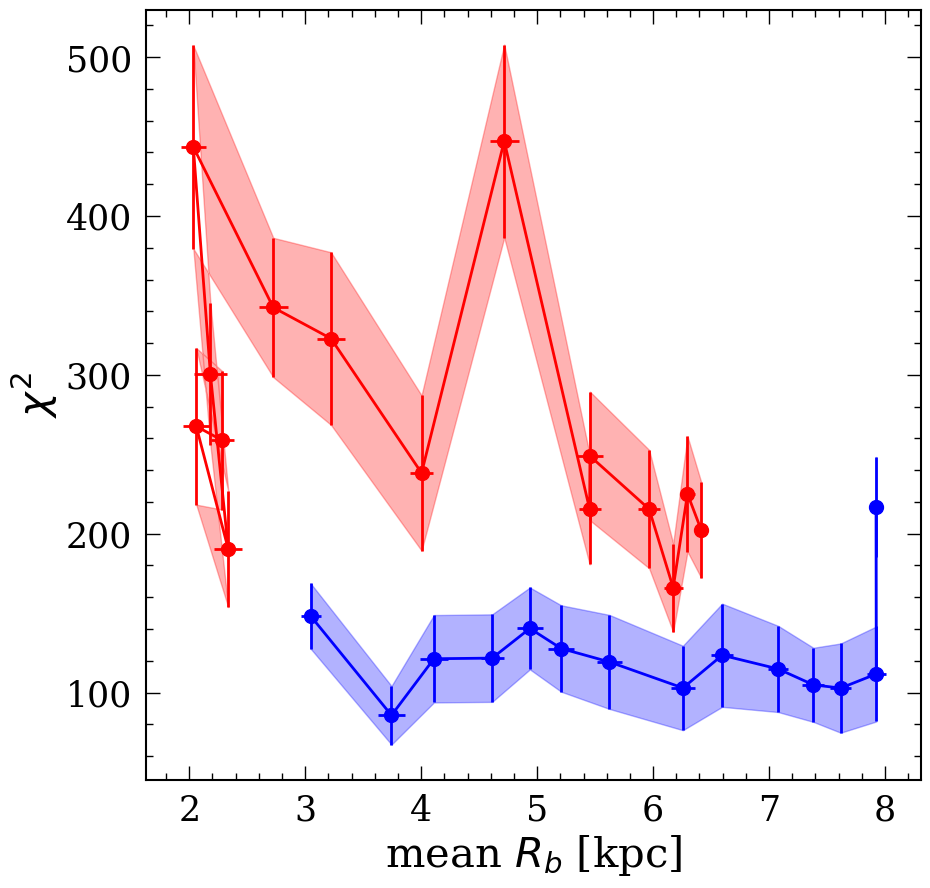

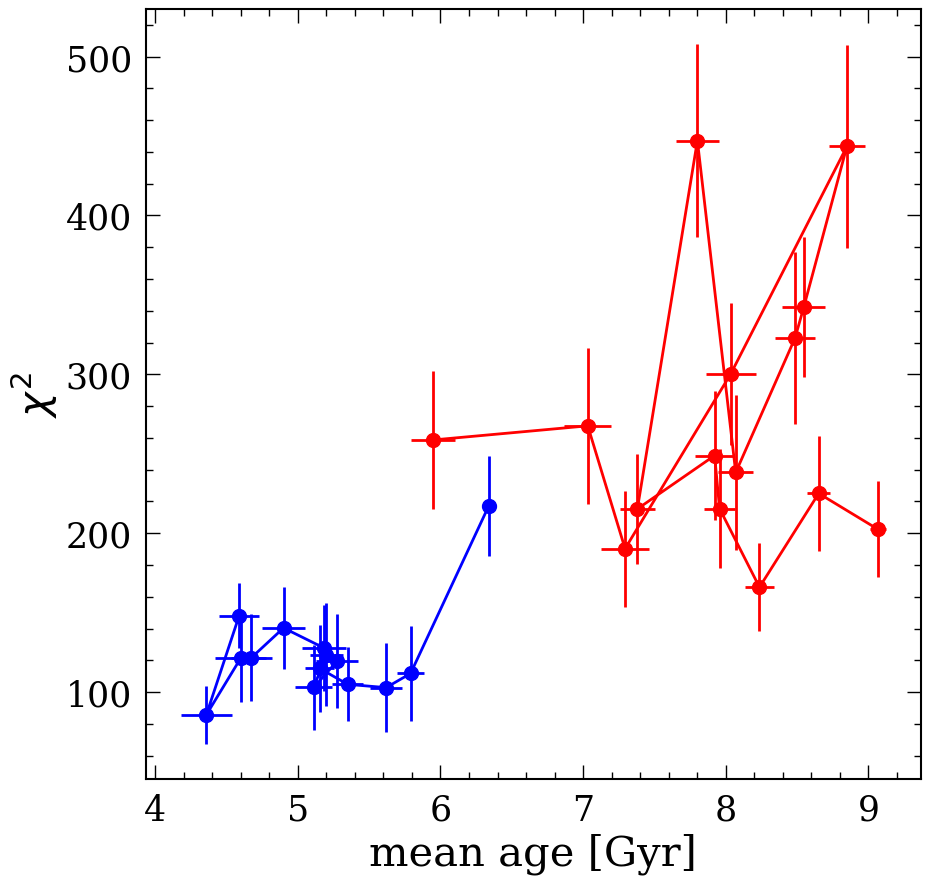

In [12]:
plt.figure()
plt.errorbar(Rbinn, chi2inn, xerr=Rbinn_err, yerr=chi2inn_err,fmt='r-o',
            markersize=10)
plt.errorbar(Rbout, chi2out, xerr=Rbout_err, yerr=chi2out_err,fmt='b-o',
            markersize=10)
plt.fill_between(Rbinn, chi2inn+chi2inn_err, y2=chi2inn-chi2inn_err,
                color='r', alpha=0.3)
plt.fill_between(Rbout, chi2out+chi2out_err, y2=chi2out-chi2out_err,
                color='b', alpha=0.3)
plt.xlabel('mean $R_b$ [kpc]')
plt.ylabel('$χ^2$')

plt.figure()
plt.errorbar(ageinn, chi2inn, xerr=ageinn_err, yerr=chi2inn_err,fmt='r-o',
            markersize=10)
plt.errorbar(ageout, chi2out, xerr=ageout_err, yerr=chi2out_err,fmt='b-o',
            markersize=10)
plt.xlabel('mean age [Gyr]')
plt.ylabel('$χ^2$')



# Simulation

In [4]:
import pynbody as pb
import numpy as np
import matplotlib.pylab as plt
import pynbody.filt as filt
from pynbody.snapshot.tipsy import TipsySnap
import os, pickle

#Asplund+2009
# solar abundances from table 1, abundance of element x
# converted to mass fractions using abundance x and atomic mass m:
# XSOLX = 10**(x-12)*m*XSOLH
XSOLH = 0.74
#XSOLHe =  
XSOLFe = 1.31e-3
XSOLO = 5.8E-3
XSOLC = 2.39e-3
XSOLN = 7e-4
XSOLNe = 1.26e-3
XSOLMg = 7.16e-4
XSOLSi = 6.7e-4
XSOLS = 3.1e-4
XSOLAl = 5.6e-5
XSOLCa = 6.48e-5
XSOLNa = 2.96e-5
XSOLZr = 2.566e-8
XSOLY = 1.067e-8
XSOLV = 3.21e-7
XSOLTi = 3.16e-6
XSOLSr = 4.8e-8
XSOLSc = 4.7e-8
XSOLNi = 7.21e-5
XSOLMn = 1.1e-5
XSOLLa = 1.29e-9
XSOLEu = 3.7e-10
XSOLCr = 1.68e-5
XSOLCo = 4.26e-6
XSOLBa = 1.54e-8


@TipsySnap.derived_quantity
def hetot(self):
    """Helium mass fraction"""
    return self['HeMassFrac_AGB'] + self['HeMassFrac_SNIA'] + self['HeMassFrac_SNII']

@TipsySnap.derived_quantity
def feh(self):
    """Iron abundance [Fe/H] derived from tipsy array FeMassFrac, with solar values from Asplund et al 09"""
    minfe = np.amin(self['FeMassFrac_AGB'][np.where(self['FeMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['FeMassFrac_SNIA'][np.where(self['FeMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['FeMassFrac_SNII'][np.where(self['FeMassFrac_SNII'] > 0)])
    self['FeMassFrac_AGB'][np.where(self['FeMassFrac_AGB'] == 0)] = minfe
    self['FeMassFrac_SNIA'][np.where(self['FeMassFrac_SNIA'] == 0)] = minfeI
    self['FeMassFrac_SNII'][np.where(self['FeMassFrac_SNII'] == 0)] = minfeII
    return np.log10((self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII']) / self['hydrogen']) - np.log10(XSOLFe / XSOLH)

                                                                         
@TipsySnap.derived_quantity
def ch(self):
    """Iron abundance [C/H] derived from tipsy array CMassFrac, with solar
    values from Asplund et al 09"""
    minfe = np.amin(self['CMassFrac_AGB'][np.where(self['CMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['CMassFrac_SNIA'][np.where(self['CMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['CMassFrac_SNII'][np.where(self['CMassFrac_SNII'] > 0)])
    self['CMassFrac_AGB'][np.where(self['CMassFrac_AGB'] == 0)] = minfe
    self['CMassFrac_SNIA'][np.where(self['CMassFrac_SNIA'] == 0)] = minfeI
    self['CMassFrac_SNII'][np.where(self['CMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['CMassFrac_AGB']+self['CMassFrac_SNIA']+self['CMassFrac_SNII']) / self['hydrogen']) - np.log10(XSOLC / XSOLH)

@TipsySnap.derived_quantity
def oh(self):
    """Iron abundance [O/H] derived from tipsy array OMassFrac, with solar
    values from Asplund et al 09"""
    minfe = np.amin(self['OMassFrac_AGB'][np.where(self['OMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['OMassFrac_SNIA'][np.where(self['OMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['OMassFrac_SNII'][np.where(self['OMassFrac_SNII'] > 0)])
    self['OMassFrac_AGB'][np.where(self['OMassFrac_AGB'] == 0)] = minfe
    self['OMassFrac_SNIA'][np.where(self['OMassFrac_SNIA'] == 0)] = minfeI
    self['OMassFrac_SNII'][np.where(self['OMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['OMassFrac_AGB']+self['OMassFrac_SNIA']+self['OMassFrac_SNII']) / self['hydrogen']) - np.log10(XSOLO / XSOLH)


@TipsySnap.derived_quantity
def sih(self):
    """Iron abundance [Si/H] derived from tipsy array SiMassFrac, with solar
    values from Asplund et al 09"""
    minfe = np.amin(self['SiMassFrac_AGB'][np.where(self['SiMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['SiMassFrac_SNIA'][np.where(self['SiMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['SiMassFrac_SNII'][np.where(self['SiMassFrac_SNII'] > 0)])
    self['SiMassFrac_AGB'][np.where(self['SiMassFrac_AGB'] == 0)] = minfe
    self['SiMassFrac_SNIA'][np.where(self['SiMassFrac_SNIA'] == 0)] = minfeI
    self['SiMassFrac_SNII'][np.where(self['SiMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['SiMassFrac_AGB']+self['SiMassFrac_SNIA']+self['SiMassFrac_SNII']) / self['hydrogen']) - np.log10(XSOLSi / XSOLH)


@TipsySnap.derived_quantity
def mgh(self):
    """Iron abundance [Mg/H] derived from tipsy array MgMassFrac, with solar
    values from Asplund et al 09"""
    minfe = np.amin(self['MgMassFrac_AGB'][np.where(self['MgMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['MgMassFrac_SNIA'][np.where(self['MgMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['MgMassFrac_SNII'][np.where(self['MgMassFrac_SNII'] > 0)])
    self['MgMassFrac_AGB'][np.where(self['MgMassFrac_AGB'] == 0)] = minfe
    self['MgMassFrac_SNIA'][np.where(self['MgMassFrac_SNIA'] == 0)] = minfeI
    self['MgMassFrac_SNII'][np.where(self['MgMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['MgMassFrac_AGB']+self['MgMassFrac_SNIA']+self['MgMassFrac_SNII']) / self['hydrogen']) - np.log10(XSOLMg / XSOLH)


@TipsySnap.derived_quantity
def sh(self):
    """Iron abundance [S/H] derived from tipsy array SMassFrac, with solar
    values from Asplund et al 09"""
    minfe = np.amin(self['SMassFrac_AGB'][np.where(self['SMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['SMassFrac_SNIA'][np.where(self['SMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['SMassFrac_SNII'][np.where(self['SMassFrac_SNII'] > 0)])
    self['SMassFrac_AGB'][np.where(self['SMassFrac_AGB'] == 0)] = minfe
    self['SMassFrac_SNIA'][np.where(self['SMassFrac_SNIA'] == 0)] = minfeI
    self['SMassFrac_SNII'][np.where(self['SMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['SMassFrac_AGB']+self['SMassFrac_SNIA']+self['SMassFrac_SNII']) / self['hydrogen']) - np.log10(XSOLS / XSOLH)


@TipsySnap.derived_quantity
def ofe(self):
    """Oxygen-to-iron ratio [O/Fe] derived from tipsy arrays OxMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['OMassFrac_AGB'][np.where(self['OMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['OMassFrac_SNIA'][np.where(self['OMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['OMassFrac_SNII'][np.where(self['OMassFrac_SNII'] > 0)])
    self['OMassFrac_AGB'][np.where(self['OMassFrac_AGB'] == 0)] = minfe
    self['OMassFrac_SNIA'][np.where(self['OMassFrac_SNIA'] == 0)] = minfeI
    self['OMassFrac_SNII'][np.where(self['OMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['OMassFrac_AGB']+self['OMassFrac_SNIA']+self['OMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLO / XSOLFe)


@TipsySnap.derived_quantity
def cfe(self):
    """Carbon-to-iron ratio [O/Fe] derived from tipsy arrays OxMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['CMassFrac_AGB'][np.where(self['CMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['CMassFrac_SNIA'][np.where(self['CMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['CMassFrac_SNII'][np.where(self['CMassFrac_SNII'] > 0)])
    self['CMassFrac_AGB'][np.where(self['CMassFrac_AGB'] == 0)] = minfe
    self['CMassFrac_SNIA'][np.where(self['CMassFrac_SNIA'] == 0)] = minfeI
    self['CMassFrac_SNII'][np.where(self['CMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['CMassFrac_AGB']+self['CMassFrac_SNIA']+self['CMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLC / XSOLFe)


@TipsySnap.derived_quantity
def cafe(self):
    """Carbon-to-iron ratio [O/Fe] derived from tipsy arrays OxMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['CaMassFrac_AGB'][np.where(self['CaMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['CaMassFrac_SNIA'][np.where(self['CaMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['CaMassFrac_SNII'][np.where(self['CaMassFrac_SNII'] > 0)])
    self['CaMassFrac_AGB'][np.where(self['CaMassFrac_AGB'] == 0)] = minfe
    self['CaMassFrac_SNIA'][np.where(self['CaMassFrac_SNIA'] == 0)] = minfeI
    self['CaMassFrac_SNII'][np.where(self['CaMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['CaMassFrac_AGB']+self['CaMassFrac_SNIA']+self['CaMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLCa / XSOLFe)


@TipsySnap.derived_quantity
def alfe(self):
    """Carbon-to-iron ratio [O/Fe] derived from tipsy arrays OxMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['AlMassFrac_AGB'][np.where(self['AlMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['AlMassFrac_SNIA'][np.where(self['AlMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['AlMassFrac_SNII'][np.where(self['AlMassFrac_SNII'] > 0)])
    self['AlMassFrac_AGB'][np.where(self['AlMassFrac_AGB'] == 0)] = minfe
    self['AlMassFrac_SNIA'][np.where(self['AlMassFrac_SNIA'] == 0)] = minfeI
    self['AlMassFrac_SNII'][np.where(self['AlMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['AlMassFrac_AGB']+self['AlMassFrac_SNIA']+self['AlMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLAl / XSOLFe)


@TipsySnap.derived_quantity
def mgfe(self):
    """Carbon-to-iron ratio [O/Fe] derived from tipsy arrays OxMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['MgMassFrac_AGB'][np.where(self['MgMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['MgMassFrac_SNIA'][np.where(self['MgMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['MgMassFrac_SNII'][np.where(self['MgMassFrac_SNII'] > 0)])
    self['MgMassFrac_AGB'][np.where(self['MgMassFrac_AGB'] == 0)] = minfe
    self['MgMassFrac_SNIA'][np.where(self['MgMassFrac_SNIA'] == 0)] = minfeI
    self['MgMassFrac_SNII'][np.where(self['MgMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['MgMassFrac_AGB']+self['MgMassFrac_SNIA']+self['MgMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLMg / XSOLFe)


@TipsySnap.derived_quantity
def sfe(self):
    """Sulfur-to-iron ratio [S/Fe] derived from tipsy arrays OxMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['SMassFrac_AGB'][np.where(self['SMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['SMassFrac_SNIA'][np.where(self['SMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['SMassFrac_SNII'][np.where(self['SMassFrac_SNII'] > 0)])
    self['SMassFrac_AGB'][np.where(self['SMassFrac_AGB'] == 0)] = minfe
    self['SMassFrac_SNIA'][np.where(self['SMassFrac_SNIA'] == 0)] = minfeI
    self['SMassFrac_SNII'][np.where(self['SMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['SMassFrac_AGB']+self['SMassFrac_SNIA']+self['SMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLS / XSOLFe)


@TipsySnap.derived_quantity
def sife(self):
    """Silicon-to-iron ratio [Si/Fe] derived from tipsy arrays SiMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['SiMassFrac_AGB'][np.where(self['SiMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['SiMassFrac_SNIA'][np.where(self['SiMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['SiMassFrac_SNII'][np.where(self['SiMassFrac_SNII'] > 0)])
    self['SiMassFrac_AGB'][np.where(self['SiMassFrac_AGB'] == 0)] = minfe
    self['SiMassFrac_SNIA'][np.where(self['SiMassFrac_SNIA'] == 0)] = minfeI
    self['SiMassFrac_SNII'][np.where(self['SiMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['SiMassFrac_AGB']+self['SiMassFrac_SNIA']+self['SiMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLSi / XSOLFe)


@TipsySnap.derived_quantity
def nfe(self):
    """Carbon-to-iron ratio [O/Fe] derived from tipsy arrays OxMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['NMassFrac_AGB'][np.where(self['NMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['NMassFrac_SNIA'][np.where(self['NMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['NMassFrac_SNII'][np.where(self['NMassFrac_SNII'] > 0)])
    self['NMassFrac_AGB'][np.where(self['NMassFrac_AGB'] == 0)] = minfe
    self['NMassFrac_SNIA'][np.where(self['NMassFrac_SNIA'] == 0)] = minfeI
    self['NMassFrac_SNII'][np.where(self['NMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['NMassFrac_AGB']+self['NMassFrac_SNIA']+self['NMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLN / XSOLFe)


@TipsySnap.derived_quantity
def nafe(self):
    """Carbon-to-iron ratio [O/Fe] derived from tipsy arrays OxMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['NaMassFrac_AGB'][np.where(self['NaMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['NaMassFrac_SNIA'][np.where(self['NaMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['NaMassFrac_SNII'][np.where(self['NaMassFrac_SNII'] > 0)])
    self['NaMassFrac_AGB'][np.where(self['NaMassFrac_AGB'] == 0)] = minfe
    self['NaMassFrac_SNIA'][np.where(self['NaMassFrac_SNIA'] == 0)] = minfeI
    self['NaMassFrac_SNII'][np.where(self['NaMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['NaMassFrac_AGB']+self['NaMassFrac_SNIA']+self['NaMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLNa / XSOLFe)


@TipsySnap.derived_quantity
def nefe(self):
    """Carbon-to-iron ratio [O/Fe] derived from tipsy arrays OxMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['NeMassFrac_AGB'][np.where(self['NeMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['NeMassFrac_SNIA'][np.where(self['NeMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['NeMassFrac_SNII'][np.where(self['NeMassFrac_SNII'] > 0)])
    self['NeMassFrac_AGB'][np.where(self['NeMassFrac_AGB'] == 0)] = minfe
    self['NeMassFrac_SNIA'][np.where(self['NeMassFrac_SNIA'] == 0)] = minfeI
    self['NeMassFrac_SNII'][np.where(self['NeMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['NeMassFrac_AGB']+self['NeMassFrac_SNIA']+self['NeMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLNe / XSOLFe)


@TipsySnap.derived_quantity
def tife(self):
    """Titanium-to-iron ratio [Ti/Fe] derived from tipsy arrays TiMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['TiMassFrac_AGB'][np.where(self['TiMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['TiMassFrac_SNIA'][np.where(self['TiMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['TiMassFrac_SNII'][np.where(self['TiMassFrac_SNII'] > 0)])
    self['TiMassFrac_AGB'][np.where(self['TiMassFrac_AGB'] == 0)] = minfe
    self['TiMassFrac_SNIA'][np.where(self['TiMassFrac_SNIA'] == 0)] = minfeI
    self['TiMassFrac_SNII'][np.where(self['TiMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['TiMassFrac_AGB']+self['TiMassFrac_SNIA']+self['TiMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLTi / XSOLFe)


@TipsySnap.derived_quantity
def scfe(self):
    """Scandium-to-iron ratio [Sc/Fe] derived from tipsy arrays ScMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['ScMassFrac_AGB'][np.where(self['ScMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['ScMassFrac_SNIA'][np.where(self['ScMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['ScMassFrac_SNII'][np.where(self['ScMassFrac_SNII'] > 0)])
    self['ScMassFrac_AGB'][np.where(self['ScMassFrac_AGB'] == 0)] = minfe
    self['ScMassFrac_SNIA'][np.where(self['ScMassFrac_SNIA'] == 0)] = minfeI
    self['ScMassFrac_SNII'][np.where(self['ScMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['ScMassFrac_AGB']+self['ScMassFrac_SNIA']+self['ScMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLSc / XSOLFe)


@TipsySnap.derived_quantity
def vfe(self):
    """Vanadium-to-iron ratio [V/Fe] derived from tipsy arrays VMassFrac and FeMassFrac
    with solar values from Asplund et al 09"""
    minfe = np.amin(self['VMassFrac_AGB'][np.where(self['VMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['VMassFrac_SNIA'][np.where(self['VMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['VMassFrac_SNII'][np.where(self['VMassFrac_SNII'] > 0)])
    self['VMassFrac_AGB'][np.where(self['VMassFrac_AGB'] == 0)] = minfe
    self['VMassFrac_SNIA'][np.where(self['VMassFrac_SNIA'] == 0)] = minfeI
    self['VMassFrac_SNII'][np.where(self['VMassFrac_SNII'] == 0)] = minfeII
    
    return np.log10((self['VMassFrac_AGB']+self['VMassFrac_SNIA']+self['VMassFrac_SNII']) / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLV / XSOLFe)


@TipsySnap.derived_quantity
def alphafe(self):
    """Alpha-to-iron ratio [alpha/Fe] derived from tipsy arrays MassFrac and FeMassFrac
    with solar values from Asplund et al 09 """
    
    # alpha = O, Mg, Si, S, Ca, Ti

    minO = np.amin(self['OMassFrac_AGB'][np.where(self['OMassFrac_AGB'] > 0)])
    minOI = np.amin(self['OMassFrac_SNIA'][np.where(self['OMassFrac_SNIA'] > 0)])
    minOII = np.amin(self['OMassFrac_SNII'][np.where(self['OMassFrac_SNII'] > 0)])
    self['OMassFrac_AGB'][np.where(self['OMassFrac_AGB'] == 0)] = minO
    self['OMassFrac_SNIA'][np.where(self['OMassFrac_SNIA'] == 0)] = minOI
    self['OMassFrac_SNII'][np.where(self['OMassFrac_SNII'] == 0)] = minOII
    
    minMg = np.amin(self['MgMassFrac_AGB'][np.where(self['MgMassFrac_AGB'] > 0)])
    minMgI = np.amin(self['MgMassFrac_SNIA'][np.where(self['MgMassFrac_SNIA'] > 0)])
    minMgII = np.amin(self['MgMassFrac_SNII'][np.where(self['MgMassFrac_SNII'] > 0)])
    self['MgMassFrac_AGB'][np.where(self['MgMassFrac_AGB'] == 0)] = minMg
    self['MgMassFrac_SNIA'][np.where(self['MgMassFrac_SNIA'] == 0)] = minMgI
    self['MgMassFrac_SNII'][np.where(self['MgMassFrac_SNII'] == 0)] = minMgII
    
    minSi = np.amin(self['SiMassFrac_AGB'][np.where(self['SiMassFrac_AGB'] > 0)])
    minSiI = np.amin(self['SiMassFrac_SNIA'][np.where(self['SiMassFrac_SNIA'] > 0)])
    minSiII = np.amin(self['SiMassFrac_SNII'][np.where(self['SiMassFrac_SNII'] > 0)])
    self['SiMassFrac_AGB'][np.where(self['SiMassFrac_AGB'] == 0)] = minSi
    self['SiMassFrac_SNIA'][np.where(self['SiMassFrac_SNIA'] == 0)] = minSiI
    self['SiMassFrac_SNII'][np.where(self['SiMassFrac_SNII'] == 0)] = minSiII
    
    minS = np.amin(self['SMassFrac_AGB'][np.where(self['SMassFrac_AGB'] > 0)])
    minSI = np.amin(self['SMassFrac_SNIA'][np.where(self['SMassFrac_SNIA'] > 0)])
    minSII = np.amin(self['SMassFrac_SNII'][np.where(self['SMassFrac_SNII'] > 0)])
    self['SMassFrac_AGB'][np.where(self['SMassFrac_AGB'] == 0)] = minS
    self['SMassFrac_SNIA'][np.where(self['SMassFrac_SNIA'] == 0)] = minSI
    self['SMassFrac_SNII'][np.where(self['SMassFrac_SNII'] == 0)] = minSII
    
    minCa = np.amin(self['CaMassFrac_AGB'][np.where(self['CaMassFrac_AGB'] > 0)])
    minCaI = np.amin(self['CaMassFrac_SNIA'][np.where(self['CaMassFrac_SNIA'] > 0)])
    minCaII = np.amin(self['CaMassFrac_SNII'][np.where(self['CaMassFrac_SNII'] > 0)])
    self['CaMassFrac_AGB'][np.where(self['CaMassFrac_AGB'] == 0)] = minCa
    self['CaMassFrac_SNIA'][np.where(self['CaMassFrac_SNIA'] == 0)] = minCaI
    self['CaMassFrac_SNII'][np.where(self['CaMassFrac_SNII'] == 0)] = minCaII
   
    minTi = np.amin(self['TiMassFrac_AGB'][np.where(self['TiMassFrac_AGB'] > 0)])
    minTiI = np.amin(self['TiMassFrac_SNIA'][np.where(self['TiMassFrac_SNIA'] > 0)])
    minTiII = np.amin(self['TiMassFrac_SNII'][np.where(self['TiMassFrac_SNII'] > 0)])
    self['TiMassFrac_AGB'][np.where(self['TiMassFrac_AGB'] == 0)] = minTi
    self['TiMassFrac_SNIA'][np.where(self['TiMassFrac_SNIA'] == 0)] = minTiI
    self['TiMassFrac_SNII'][np.where(self['TiMassFrac_SNII'] == 0)] = minTiII
    
    minfe = np.amin(self['FeMassFrac_AGB'][np.where(self['FeMassFrac_AGB'] > 0)])
    minfeI = np.amin(self['FeMassFrac_SNIA'][np.where(self['FeMassFrac_SNIA'] > 0)])
    minfeII = np.amin(self['FeMassFrac_SNII'][np.where(self['FeMassFrac_SNII'] > 0)])
    self['FeMassFrac_AGB'][np.where(self['FeMassFrac_AGB'] == 0)] = minfe
    self['FeMassFrac_SNIA'][np.where(self['FeMassFrac_SNIA'] == 0)] = minfeI
    self['FeMassFrac_SNII'][np.where(self['FeMassFrac_SNII'] == 0)] = minfeII
    
    alpha = (self['OMassFrac_AGB']+self['OMassFrac_SNIA']+self['OMassFrac_SNII']) + (self['MgMassFrac_AGB']+self['MgMassFrac_SNIA']+self['MgMassFrac_SNII']) + (self['SiMassFrac_AGB']+self['SiMassFrac_SNIA']+self['SiMassFrac_SNII']) + (self['SMassFrac_AGB']+self['SMassFrac_SNIA']+self['SMassFrac_SNII']) + (self['CaMassFrac_AGB']+self['CaMassFrac_SNIA']+self['CaMassFrac_SNII']) + (self['TiMassFrac_AGB']+self['TiMassFrac_SNIA']+self['TiMassFrac_SNII'])
    XSOLALPHA = XSOLO + XSOLMg + XSOLSi + XSOLS + XSOLCa + XSOLTi
    return np.log10(alpha / (self['FeMassFrac_AGB']+self['FeMassFrac_SNIA']+self['FeMassFrac_SNII'])) - np.log10(XSOLALPHA / XSOLFe)

@TipsySnap.derived_quantity
def co(self):
    c = 10**(self['ch'] - 12) #4.9e-4 * 10**self['ch']
    o = 10**(self['oh'] - 12) #2.7e-4 * 10**self['oh']
    return c/o


############################################################################
# Galah comparison plot
############################################################################
def setup_abundance_plot(axes=None, elem_list=['alphafe','O','C','Si','Mg','Al','Ca','Na','Ti'], 
                         label=[r'$\rm{[\alpha/Fe]}$',r'$\rm{[O/Fe]}$',r'$\rm{[C/Fe]}$',r'$\rm{[Si/Fe]}$',r'$\rm{[Mg/Fe]}$',
                                r'$\rm{[Al/Fe]}$',r'$\rm{[Ca/Fe]}$',r'$\rm{[Na/Fe]}$',r'$\rm{[Ti/Fe]}$'], galah='./data/Buder_2019.fits'):
    '''
    Create a figure object to plot the stellar abundance tracks [X/Fe] vs. [Fe/H] for several elements X 
    as provided by elem_list. 
    If additionally galah is set to the path where the Galah data is, the observational data of the solar 
    neighbourhood from the Galah survey is plotted as well.
    '''
    
    import matplotlib.gridspec as gridspec
    
    N_lines = int(np.ceil(len(elem_list)/3.))
    
    if axes is None:
        fig = plt.figure(figsize=(30,5*N_lines))
        gs = gridspec.GridSpec(N_lines+1, 3, width_ratios=[1,1,1], height_ratios=[0.05]+[.5]*N_lines)
        gs.update(hspace=0.0, wspace=0.0)
                         
        cbaxis = plt.subplot(gs[0:3])
        axis = []
        for i in range(len(elem_list)):
            axis.append(plt.subplot(gs[3+i]))
            if i < len(elem_list) - 3:
                axis[-1].set_xticklabels([])
            if not (i%3 == 0):
                axis[-1].set_yticklabels([])
            axis[-1].text( 0.8, 0.85, label[i], color='k', fontsize=35, transform=axis[-1].transAxes )
            
            
        axis[-3].set_xlabel(r'$\rm{[Fe/H]}$')
        axis[-2].set_xlabel(r'$\rm{[Fe/H]}$')
        axis[-1].set_xlabel(r'$\rm{[Fe/H]}$')
        
    if galah:
        from astropy.io import fits
        if os.path.isfile(galah):
            hdul = fits.open(galah)
            for i in range(len(elem_list)):
                #try:
                if elem_list[i] == 'alphafe':
                    obs_data = hdul[1].data['__alpha_Fe_']
                else:
                    obs_data = hdul[1].data[elem_list[i]+'Abund']
                Fe_data = hdul[1].data['__Fe_H_']
                hist, xe, ye = np.histogram2d(Fe_data,obs_data,bins=50, range=((-1,.5),(-.5,.75)))
                    #X, Y = np.meshgrid(xe[:-1], ye[:-1])
                    #axis[i].contour(X, Y, np.log10(hist), 5, cmap='RdGy_r')
                axis[i].contour(np.log10(hist).T/np.max(np.log10(hist)),extent=[xe[0],xe[-1],ye[0],ye[-1]], cmap='RdGy_r', levels=[0.3,0.5,0.7,.9], alpha=0.75, zorder=5)
        
                #except:
                #    print("Element %s not in Galah table."%elem_list[i])
                
                axis[i].plot([-1,.5],[0,0], c='gray')
                axis[i].plot([0,0],[-.5,.75], c='gray')
        else:
            print('Could not open Galah data at path: %s.'%galah)

    return axis, cbaxis, fig

#########################################################################################


def plot_hist(x,y,z,weight,clabel):
    hist, xe, ye = np.histogram2d(x,y,bins=80,weights=z*weight)
    mass, xe, ye = np.histogram2d(x,y,bins=80,weights=weight)

    if clabel == '$\log(M/[M_\odot]$)':
        c = plt.imshow(np.log10(mass), cmap='plasma', extent=(-20,20,-20,20))
    else:
        c = plt.imshow(hist/mass, cmap='plasma', extent=(-20,20,-20,20), vmin=-.6, vmax=.6)

    plt.xlabel(r'$x$ [kpc]')
    plt.ylabel(r'$y$ [kpc]')
    plt.colorbar(c, label=clabel)
    return hist/mass, xe, ye

def alphafeh(sim, x_key,  y_key, xlabel, ylabel, filename):
    plt.clf()
    mass, xe, ye = np.histogram2d(sim.s[x_key],sim.s[y_key],weights=(sim.s['mass']), bins=200, range=((-2,0.5),(-.25,0.5)))
    a = plt.imshow(np.log10(mass.T), origin='lower', cmap='plasma', extent=(-2.,0.5,-.25,0.5),aspect='auto')
    cb = plt.colorbar(a, orientation='horizontal')
    cb.set_label(r'$M_{\rm star}$ [$M_\odot$]',labelpad=10)
    #cb.ax.xaxis.set_ticks_position('top')
    #cb.ax.xaxis.set_label_position('top')
    plt.plot([0,0],[-.25,0.5],c='gray',lw=1)
    plt.plot([-2,.5],[0,0.],c='gray',lw=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

def alphafeh2(sim, x_key,  y_key, ax=False, xlabel='[Fe/H]', ylabel='[alpha/Fe]', filename='alpha_fe'):
    mass, xe, ye = np.histogram2d(sim.s[x_key],sim.s[y_key],weights=(sim.s['mass']), bins=125, range=((-1,0.5),(-.5,0.5)))
    if ax:
        a = ax.imshow(np.log10(mass.T), origin='lower', cmap='plasma', extent=(-1.,0.5,-.5,0.5), aspect='auto', zorder=-1)
        ax.set_xlim(-1,0.5)
        ax.set_ylim(-.5,.75)
        if filename:
            file = open(filename+'.dat','w')
            pickle.dump({'mass':mass,'xe':xe,'ye':ye,'range':(-1.,0.5,-.5,0.5)},file)
            file.close()
    else:
        plt.clf()
        a = plt.imshow(np.log10(mass.T), origin='lower', cmap='plasma', extent=(-1.,0.5,-.5,0.5),aspect='auto',zorder=-1)
        cb = plt.colorbar(a, orientation='horizontal')
        cb.set_label(r'$M_{\rm star}$ [$M_\odot$]',labelpad=10)
        plt.plot([0,0],[-.5,0.5],c='gray',lw=1)
        plt.plot([-1,.5],[0,0.],c='gray',lw=1)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if filename:
            plt.savefig(filename+'.pdf', bbox_inches='tight')
        plt.clf()
    return a

def cofeh(sim, x_key,  y_key, xlabel, ylabel, filename):
    plt.clf()
    mass, xe, ye = np.histogram2d(sim.s[x_key],sim.s[y_key],weights=(sim.s['mass']), bins=500, range=((-2,0.5),(0,1)))
    a = plt.imshow(np.log10(mass.T), origin='lower', cmap='plasma', extent=(-2.,0.5,0,1),aspect='auto')
    cb = plt.colorbar(a, orientation='horizontal')
    cb.set_label(r'$M_{\rm star}$ [$M_\odot$]',labelpad=10)
    #cb.ax.xaxis.set_ticks_position('top')
    #cb.ax.xaxis.set_label_position('top')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

##############################################################################################################
# main part
##############################################################################################################

simname = 'g8.26e11_lowres' #'g8.26e11_alt_yield_2' #'g7.55e11_alt_yield' #'g2.79e12' #'g2.19e11' #'g2.79e12' #'g7.55e11'
prefix = 'g8.26e11'
snap = '01024'
path = './'
outpath = './'

s = pb.load(path+simname+'/'+prefix+'.'+snap)
h=s.halos()
pb.analysis.angmom.faceon(h[1])
s.physical_units()

disc = filt.Disc('20 kpc', '2 kpc')
solar = filt.LowPass('r', '9 kpc') & filt.HighPass('r', '7 kpc')
young = filt.LowPass('age', '1 Gyr')
sim = h[1].s[disc]
sol = h[1].s[solar & disc]

In [5]:
#plot_list = ['mass','feh','ch','oh','sih','mgh','sh']
#plot_name = ['$\log(M/[M_\odot]$)','[Fe/H]','[C/H]','[O/H]','[Si/H]','[Mg/H]','[S/H]']

#alphafeh(sim, 'feh', 'ch', '[Fe/H]', '[C/H]', outpath+simname+'_ch_feh.pdf')
alphafeh(sim, 'feh', 'ofe', '[Fe/H]', '[O/Fe]', outpath+simname+'_ofe_feh.pdf')
alphafeh(sim, 'feh', 'cfe', '[Fe/H]', '[C/Fe]', outpath+simname+'_cfe_feh.pdf')
alphafeh(sim, 'feh', 'mgfe', '[Fe/H]', '[Mg/Fe]', outpath+simname+'_mgfe_feh.pdf')
alphafeh(sim, 'feh', 'sfe', '[Fe/H]', '[S/Fe]', outpath+simname+'_sfe_feh.pdf')
alphafeh(sim, 'feh', 'sife', '[Fe/H]', '[Si/Fe]', outpath+simname+'_sife_feh.pdf')
alphafeh(sim, 'feh', 'nfe', '[Fe/H]', '[N/Fe]', outpath+simname+'_nfe_feh.pdf')
alphafeh(sim, 'feh', 'alfe', '[Fe/H]', '[Al/Fe]', outpath+simname+'_alfe_feh.pdf')
#alphafeh(sim, 'feh', 'cafe', '[Fe/H]', '[Ca/Fe]', outpath+simname+'_cafe_feh.pdf')
alphafeh(sim, 'feh', 'nafe', '[Fe/H]', '[Na/Fe]', outpath+simname+'_nafe_feh.pdf')
alphafeh(sim, 'feh', 'nefe', '[Fe/H]', '[Ne/Fe]', outpath+simname+'_nefe_feh.pdf')
alphafeh(sim, 'feh', 'tife', '[Fe/H]', '[Ti/Fe]', outpath+simname+'_tife_feh.pdf')
#alphafeh(sim, 'feh', 'scfe', '[Fe/H]', '[Sc/Fe]', outpath+simname+'_scfe_feh.pdf')
#alphafeh(sim, 'feh', 'vfe', '[Fe/H]', '[V/Fe]', outpath+simname+'_vfe_feh.pdf')

/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_1640/1508903944.py:458: RuntimeWarning: divide by zero encountered in log10
  a = plt.imshow(np.log10(mass.T), origin='lower', cmap='plasma', extent=(-2.,0.5,-.25,0.5),aspect='auto')
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_1640/1508903944.py:458: RuntimeWarning: divide by zero encountered in log10
  a = plt.imshow(np.log10(mass.T), origin='lower', cmap='plasma', extent=(-2.,0.5,-.25,0.5),aspect='auto')
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_1640/1508903944.py:458: RuntimeWarning: divide by zero encountered in log10
  a = plt.imshow(np.log10(mass.T), origin='lower', cmap='plasma', extent=(-2.,0.5,-.25,0.5),aspect='auto')
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_1640/1508903944.py:458: RuntimeWarning: divide by zero encountered in log10
  a = plt.imshow(np.log10(mass.T), origin='lower', cmap='plasma', extent=(-2.,0.5,-.25,0.5),aspect='auto')
/var/folders/w0/h14c78gj4rs91wsb

<Figure size 1000x1000 with 0 Axes>

In [7]:
sim.s['age']

SimArray([1.39139690e+01, 1.39139690e+01, 1.39131070e+01, ...,
          1.23361833e-05, 1.23361833e-05, 1.23361833e-05], 'kpc s km**-1')

In [8]:
feherr = np.mean(df['[Fe/H]_err'])
mgfeerr = np.mean(df['[Mg/Fe]_err'])
m = (abs(sim.s['r']-10)<5)&(sim.s['feh']>-0.1)
df_sim = pd.DataFrame(np.array((sim.s['feh'][m], sim.s['mgfe'][m], 
                              sim.s['ofe'][m],sim.s['sife'][m],sim.s['sfe'][m],
                               sim.s['cafe'][m],sim.s['tife'][m],sim.s['cfe'][m],
                       sim.s['nfe'][m],sim.s['alfe'][m],sim.s['age'][m])).T,
                      columns=['[Fe/H]','[Mg/Fe]','[O/Fe]','[Si/Fe]','[S/Fe]','[Ca/Fe]','[Ti/Fe]','[C/Fe]',\
                       '[N/Fe]','[Al/Fe]','age'])

In [9]:
simele = ['[Fe/H]','[Mg/Fe]','[O/Fe]','[Si/Fe]','[S/Fe]','[Ca/Fe]','[Ti/Fe]','[C/Fe]', '[N/Fe]','[Al/Fe]']
for j in simele:
    dataerr = np.mean(df[j+'_err'])
    df_sim[j] = np.array([np.random.normal(i, dataerr, 1)  for i in df_sim[j]], dtype=float)
    df_sim[j+'_err'] = dataerr
    


0.03965517241379313


Text(0, 0.5, '[Mg/Fe]')

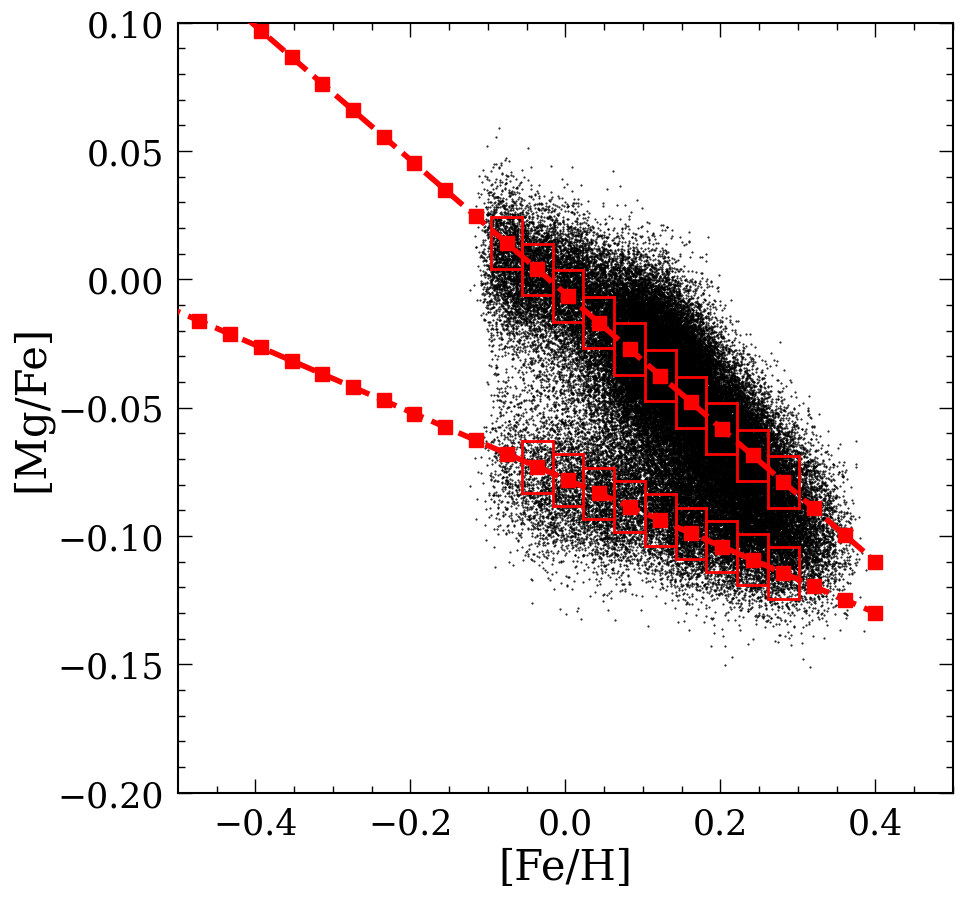

In [10]:
plt.plot(df_sim['[Fe/H]'], df_sim['[Mg/Fe]'],'k.',
          markersize=1)



mgfe_ylim = [0.19,-0.11]
mgfe_ylim_low = [0.02,-0.13]
mgfe_boxsize = 0.01
numbselect = 200

plt.plot([-0.75,0.4],[mgfe_ylim[0],mgfe_ylim[1]], 'r--', linewidth=4, zorder=10)
p_inner = fitpoints([-0.75,0.4],[mgfe_ylim[0],mgfe_ylim[1]])
plt.plot([-0.75,0.4],[mgfe_ylim_low[0],mgfe_ylim_low[1]], 'r--', linewidth=4, zorder=10)
p_lowalpha = fitpoints([-0.75,0.4],[mgfe_ylim_low[0],mgfe_ylim_low[1]])

# draw some bins
fehbins = np.linspace(-0.75,0.4,30)
#fehbins = fehbins[2:]
print(np.diff(fehbins)[0])

dfeh = np.diff(fehbins)[0]/2

plt.plot(fehbins, p_lowalpha(fehbins), 'rs', markersize=10)
plt.plot(fehbins, p_inner(fehbins), 'rs', markersize=10)

for i in range(len(fehbins)-1):
    df_inner_feh = df_sim.loc[(df_sim['[Fe/H]']>fehbins[i]-dfeh)&(df_sim['[Fe/H]']<fehbins[i]+dfeh)]
    df_lowalpha_feh = df_sim.loc[(df_sim['[Fe/H]']>fehbins[i]-dfeh)&(df_sim['[Fe/H]']<fehbins[i]+dfeh)]

    df_inner_feh_2 = df_sim.loc[(df_sim['[Fe/H]']>fehbins[i+1]-dfeh)&(df_sim['[Fe/H]']<fehbins[i+1]+dfeh)]
    df_lowalpha_feh_2 = df_sim.loc[(df_sim['[Fe/H]']>fehbins[i+1]-dfeh)&(df_sim['[Fe/H]']<fehbins[i+1]+dfeh)]

    # inner box compare
    inner_firstbox = df_inner_feh.loc[(df_inner_feh['[Mg/Fe]']>p_inner(fehbins[i])-mgfe_boxsize)&(df_inner_feh['[Mg/Fe]']<p_inner(fehbins[i])+mgfe_boxsize)]
    inner_secbox = df_inner_feh_2.loc[(df_inner_feh_2['[Mg/Fe]']>p_inner(fehbins[i+1])-mgfe_boxsize)&(df_inner_feh_2['[Mg/Fe]']<p_inner(fehbins[i+1])+mgfe_boxsize)]

    # outer box compare
    outer_firstbox = df_lowalpha_feh.loc[(df_lowalpha_feh['[Mg/Fe]']>p_lowalpha(fehbins[i])-mgfe_boxsize)&(df_lowalpha_feh['[Mg/Fe]']<p_lowalpha(fehbins[i])+mgfe_boxsize)]
    outer_secbox = df_lowalpha_feh_2.loc[(df_lowalpha_feh_2['[Mg/Fe]']>p_lowalpha(fehbins[i+1])-mgfe_boxsize)&(df_lowalpha_feh_2['[Mg/Fe]']<p_lowalpha(fehbins[i+1])+mgfe_boxsize)]



    if (len(inner_firstbox)>=numbselect)&(len(inner_secbox)>=numbselect):
        plt.plot([fehbins[i]-dfeh, fehbins[i]+dfeh], 
            [p_inner(fehbins[i])-mgfe_boxsize, p_inner(fehbins[i])-mgfe_boxsize],'r-',
            linewidth=2)
        plt.plot([fehbins[i]-dfeh, fehbins[i]+dfeh], 
                [p_inner(fehbins[i])+mgfe_boxsize, p_inner(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]-dfeh, fehbins[i]-dfeh], 
                [p_inner(fehbins[i])-mgfe_boxsize, p_inner(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]+dfeh, fehbins[i]+dfeh], 
                [p_inner(fehbins[i])-mgfe_boxsize, p_inner(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
    
    if (len(outer_firstbox)>=numbselect)&(len(outer_secbox)>=numbselect):
        plt.plot([fehbins[i]-dfeh, fehbins[i]+dfeh], 
                [p_lowalpha(fehbins[i])-mgfe_boxsize, p_lowalpha(fehbins[i])-mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]-dfeh, fehbins[i]+dfeh], 
                [p_lowalpha(fehbins[i])+mgfe_boxsize, p_lowalpha(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]-dfeh, fehbins[i]-dfeh], 
                [p_lowalpha(fehbins[i])-mgfe_boxsize, p_lowalpha(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)
        plt.plot([fehbins[i]+dfeh, fehbins[i]+dfeh], 
                [p_lowalpha(fehbins[i])-mgfe_boxsize, p_lowalpha(fehbins[i])+mgfe_boxsize],'r-',
                linewidth=2)



plt.xlim([-0.5,0.5])
plt.ylim([-0.2,0.1])
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')

In [11]:
from astropy.stats import bootstrap

def samples(abun, abun_err, xs, xs_err,n,fehs_val,delta_feh):
    
    samples_abun = np.zeros((len(abun),n))
    samples_xs = np.zeros((len(abun),n))
    samples_median = np.zeros((n))
    n_samples = len(abun)
    
    # create the bootstrap samples  
    # in order to sample the distribution using bootstrap with resampling and to get the correct
    # information for every star picked, we need to sample an id array, and use that to pick out the sampled stars
    # otherwise you get incorrect fehs for every abundance
    random_ids = np.arange(len(abun))
    samples_indices = bootstrap(random_ids, n).astype(int)
      
    for indx3, k in enumerate(samples_indices):
        # find the stars with the correct id
        mask_feh = (xs[k] < delta_feh+fehs_val)&(xs[k] > fehs_val-delta_feh)
        samples_median[indx3] = np.nanmedian(abun[k][mask_feh])
    return samples_median

def find_mean_scatter_norm(abundances, abundances_err,xs,xs_err,fehs_val = -1,delta_feh=0.05,n=1000):


    abundances_list = ['[O/Fe]','[Mg/Fe]','[Si/Fe]','[S/Fe]','[Ca/Fe]','[Ti/Fe]','[C/Fe]',\
                       '[N/Fe]','[Al/Fe]']
    
    xfe_mean = np.zeros((len(abundances)))
    xfe_scatter = np.zeros((len(abundances)))
    xfe_meanerr = np.zeros((len(abundances)))
    samples_median = np.zeros((len(abundances),n))
    for indx, i in enumerate(abundances):
        # make sure you are comparing stars with same logg (already did this when correcting systematics)
        # abundances compared here are between 1 < logg < 2        
        abun = i # abundances in the sample
        xs2 = xs[indx] # feh values in the sample
        abun_err = abundances_err[indx] # errors in the abundances in the sample
        xs2_err = xs_err[indx] # errors in the feh values in the sample

        # draw N samples for every x and y point, fit a line to every N distribution of the x, y plane, and get
        # the mean and sigma values of your slope and intercept
        samples_median_raw = samples(abun, abun_err, xs2, xs2_err,n,fehs_val,delta_feh)
        samples_median[indx] = samples_median_raw
        # determine the mean value of the abundances calculated by taking the mean value of the 1,000 medians
        # also calculate the sigma by taking the standard deviation of the 1,000 medians
        xfe_mean[indx] = np.nanmean(samples_median_raw)
        xfe_scatter[indx] = np.nanstd(samples_median_raw)
        xfe_meanerr[indx] = np.nanstd(samples_median_raw)/np.sqrt(len(samples_median_raw))
    return xfe_mean,xfe_scatter,xfe_meanerr


def getdata(df):
    abun = np.array((df['[O/Fe]'].values,df['[Mg/Fe]'].values,df['[Si/Fe]'].values,df['[S/Fe]'].values,\
                    df['[Ca/Fe]'].values,df['[Ti/Fe]'].values,df['[C/Fe]'].values,df['[N/Fe]'].values,\
                    df['[Al/Fe]'].values))
    abun_err = np.array((df['[O/Fe]_err'].values,df['[Mg/Fe]_err'].values,df['[Si/Fe]_err'].values,df['[S/Fe]_err'].values,\
                        df['[Ca/Fe]_err'].values,df['[Ti/Fe]_err'].values,df['[C/Fe]_err'].values,df['[N/Fe]_err'].values,\
                        df['[Al/Fe]_err'].values))
    feh = np.array((df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,\
                        df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,df['[Fe/H]'].values,\
                        df['[Fe/H]'].values))
    feh_err = np.array((df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,\
                        df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,df['[Fe/H]_err'].values,\
                        df['[Fe/H]_err'].values))
    
    return abun, abun_err, feh, feh_err

from scipy import stats

abundances_list = ['[O/Fe]','[Mg/Fe]','[Si/Fe]','[S/Fe]','[Ca/Fe]','[Ti/Fe]','[C/Fe]','[N/Fe]','[Al/Fe]']
def get_chi2(observed_mean,predicted_mean, observed_error, predicted_error):
    from scipy import stats
    
    result = np.zeros((len(observed_mean)))
    for indx, i in enumerate(observed_mean):
        result[indx] = ((i-predicted_mean[indx])**2)/(observed_error[indx]**2+predicted_error[indx]**2)
    chi2 = np.sum((result))
    return chi2

def get_diff(observed_mean,predicted_mean):
    result = np.zeros((len(observed_mean)))
    for indx, i in enumerate(observed_mean):
        result[indx] = ((i-predicted_mean[indx])**2)
    diff = np.sum((result))
    return diff

In [14]:
testtime = 100

allchi2_inn = np.zeros((len(fehbins)-2,testtime))
allchi2_out = np.zeros((len(fehbins)-2,testtime))
diff_inn = np.zeros((len(fehbins)-2,testtime))
diff_out = np.zeros((len(fehbins)-2,testtime))


nbs_inn = np.zeros((len(fehbins)-2,testtime))
nbs_out = np.zeros((len(fehbins)-2,testtime))
rb_inn = np.zeros((len(fehbins)-2,testtime))
rb_out = np.zeros((len(fehbins)-2,testtime))
age_inn = np.zeros((len(fehbins)-2,testtime))
age_out = np.zeros((len(fehbins)-2,testtime))


for j in trange(testtime):
    for i in range(len(fehbins)-2):
        df_inner_feh = df_sim.loc[(df_sim['[Fe/H]']>fehbins[i]-dfeh)&(df_sim['[Fe/H]']<fehbins[i]+dfeh)]
        df_lowalpha_feh = df_sim.loc[(df_sim['[Fe/H]']>fehbins[i]-dfeh)&(df_sim['[Fe/H]']<fehbins[i]+dfeh)]

        df_inner_feh_2 = df_sim.loc[(df_sim['[Fe/H]']>fehbins[i+1]-dfeh)&(df_sim['[Fe/H]']<fehbins[i+1]+dfeh)]
        df_lowalpha_feh_2 = df_sim.loc[(df_sim['[Fe/H]']>fehbins[i+1]-dfeh)&(df_sim['[Fe/H]']<fehbins[i+1]+dfeh)]

        # inner box compare
        inner_firstbox = df_inner_feh.loc[(df_inner_feh['[Mg/Fe]']>p_inner(fehbins[i])-mgfe_boxsize)&(df_inner_feh['[Mg/Fe]']<p_inner(fehbins[i])+mgfe_boxsize)]
        inner_secbox = df_inner_feh_2.loc[(df_inner_feh_2['[Mg/Fe]']>p_inner(fehbins[i+1])-mgfe_boxsize)&(df_inner_feh_2['[Mg/Fe]']<p_inner(fehbins[i+1])+mgfe_boxsize)]

        # outer box compare
        outer_firstbox = df_lowalpha_feh.loc[(df_lowalpha_feh['[Mg/Fe]']>p_lowalpha(fehbins[i])-mgfe_boxsize)&(df_lowalpha_feh['[Mg/Fe]']<p_lowalpha(fehbins[i])+mgfe_boxsize)]
        outer_secbox = df_lowalpha_feh_2.loc[(df_lowalpha_feh_2['[Mg/Fe]']>p_lowalpha(fehbins[i+1])-mgfe_boxsize)&(df_lowalpha_feh_2['[Mg/Fe]']<p_lowalpha(fehbins[i+1])+mgfe_boxsize)]


        if (len(inner_firstbox)>=numbselect)&(len(inner_secbox)>=numbselect):
            # abundances for inner box
            inner_firstbox = inner_firstbox.sample(n = numbselect)
            inner_secbox = inner_secbox.sample(n = numbselect)
            abun_inner_firstbox, abun_inner_firstbox_err, feh_inner_firstbox, feh_inner_firstbox_err = getdata(inner_firstbox)
            abun_inner_secbox, abun_inner_secbox_err, feh_inner_secbox, feh_inner_secbox_err = getdata(inner_secbox)

            # calculate for two inner
            xfe_mean_inner_firstbox ,xfe_scatter_inner_firstbox ,xfe_meanerr_inner_firstbox = find_mean_scatter_norm(abun_inner_firstbox, abun_inner_firstbox_err, feh_inner_firstbox, feh_inner_firstbox_err, fehs_val = fehbins[i] )
            xfe_mean_inner_secbox ,xfe_scatter_inner_secbox ,xfe_meanerr_inner_secbox = find_mean_scatter_norm(abun_inner_secbox, abun_inner_secbox_err, feh_inner_secbox, feh_inner_secbox_err, fehs_val = fehbins[i+1] )

            allchi2_inn[i,j] = get_chi2(xfe_mean_inner_firstbox, xfe_mean_inner_secbox, xfe_scatter_inner_firstbox, xfe_scatter_inner_secbox)
            diff_inn[i,j] = get_diff(xfe_mean_inner_firstbox, xfe_mean_inner_secbox)
            nbs_inn[i,j] = min(len(inner_firstbox), len(inner_secbox))
            #rb_inn[i,j] = np.mean(pd.concat([inner_firstbox, outer_secbox])['Rb'])
            age_inn[i,j] = np.mean(pd.concat([inner_firstbox, outer_secbox])['age'])
            
        else:
            allchi2_inn[i,j] = np.nan
            diff_inn[i,j] = np.nan
            #rb_inn[i,j] = np.nan
            age_inn[i,j] = np.nan


        if (len(outer_firstbox)>=numbselect)&(len(outer_secbox)>=numbselect):
            # abundances for outer box
            outer_firstbox = outer_firstbox.sample(n = numbselect)
            outer_secbox = outer_secbox.sample(n = numbselect)
            abun_outer_firstbox, abun_outer_firstbox_err, feh_outer_firstbox, feh_outer_firstbox_err = getdata(outer_firstbox)
            abun_outer_secbox, abun_outer_secbox_err, feh_outer_secbox, feh_outer_secbox_err = getdata(outer_secbox)

            # calculate for two outer
            xfe_mean_outer_firstbox ,xfe_scatter_outer_firstbox ,xfe_meanerr_outer_firstbox = find_mean_scatter_norm(abun_outer_firstbox, abun_outer_firstbox_err, feh_outer_firstbox, feh_outer_firstbox_err, fehs_val = fehbins[i] )
            xfe_mean_outer_secbox ,xfe_scatter_outer_secbox ,xfe_meanerr_outer_secbox = find_mean_scatter_norm(abun_outer_secbox, abun_outer_secbox_err, feh_outer_secbox, feh_outer_secbox_err, fehs_val = fehbins[i+1] )

            allchi2_out[i,j] = get_chi2(xfe_mean_outer_firstbox, xfe_mean_outer_secbox, xfe_scatter_outer_firstbox, xfe_scatter_outer_secbox)
            diff_out[i,j] = get_diff(xfe_mean_outer_firstbox, xfe_mean_outer_secbox)
            nbs_out[i,j] = min(len(outer_firstbox), len(outer_secbox))
            #rb_out[i,j] = np.mean(pd.concat([outer_firstbox, outer_secbox])['Rb'])
            age_out[i,j] = np.mean(pd.concat([outer_firstbox, outer_secbox])['age'])
            
        else:
            allchi2_out[i,j] = np.nan
            diff_out[i,j] = np.nan
            #rb_out[i,j] = np.nan
            age_out[i,j] = np.nan


    
#nbs_inn, nbs_out


100%|█████████████████████████████████████████| 100/100 [24:04<00:00, 14.45s/it]


"plt.twinx()\nplt.plot(fehbinsmid[:-1], nbs_inn, 'r--')\nplt.plot(fehbinsmid[:-1], nbs_out, 'b--')\nplt.ylabel('# of stars')"

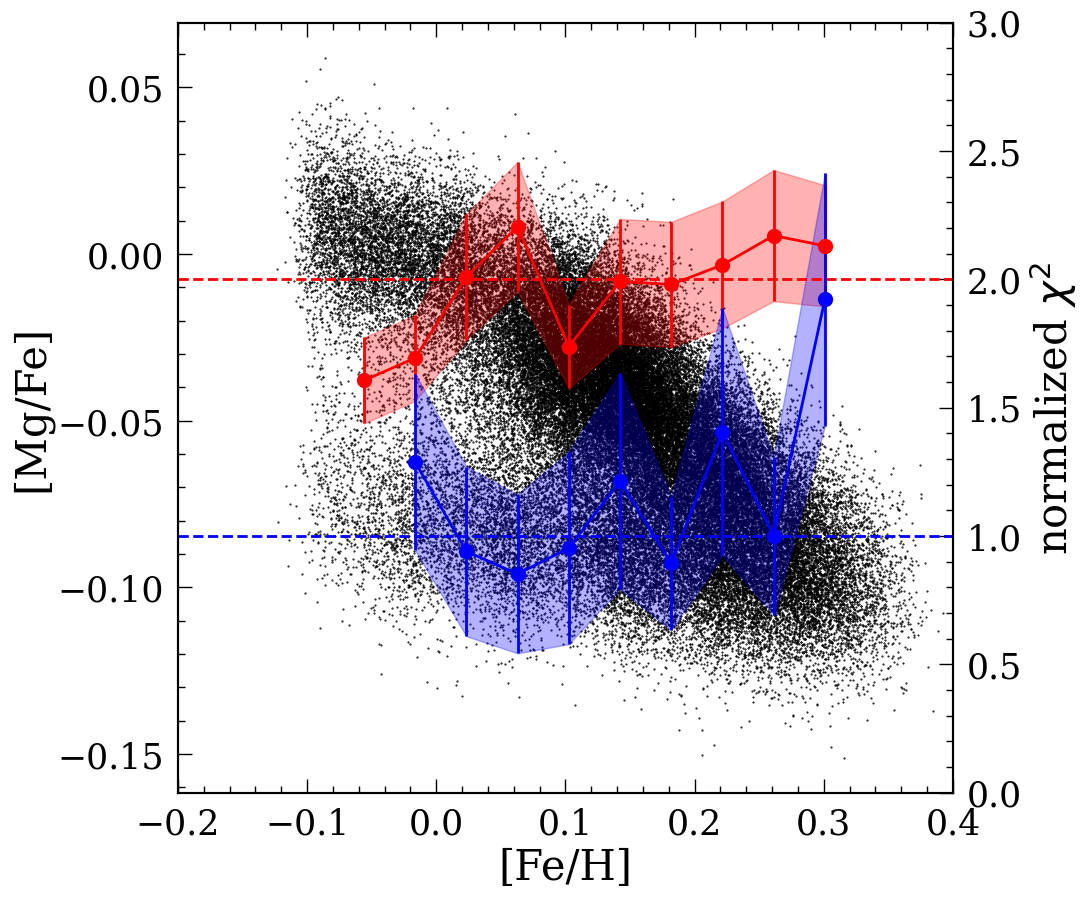

In [15]:
fehbinsmid = (fehbins[:-1]+fehbins[1:])/2

plt.plot(df_sim['[Fe/H]'], df_sim['[Mg/Fe]'], 'k.', markersize=1,
        zorder=1)

plt.xlim([-0.5,0.5])
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')

chi2inn = np.array([np.median(allchi2_inn[i,:]) for i in range(len(allchi2_inn[:,0]))])
chi2inn_err = np.array([np.std(allchi2_inn[i,:]) for i in range(len(allchi2_inn[:,0]))])

chi2out = np.array([np.median(allchi2_out[i,:]) for i in range(len(allchi2_out[:,0]))])
chi2out_err = np.array([np.std(allchi2_out[i,:]) for i in range(len(allchi2_out[:,0]))])


plt.twinx()
medinn = np.median(chi2inn[chi2inn==chi2inn])
medout = np.median(chi2out[chi2out==chi2out])
plt.errorbar(fehbinsmid[:-1], chi2inn/medinn+1, yerr=chi2inn_err/medinn,
              fmt='r-o',markersize=10, zorder=100)
plt.errorbar(fehbinsmid[:-1], chi2out/medout, yerr=chi2out_err/medout,
              fmt='b-o', markersize=10, zorder=100)
plt.fill_between(fehbinsmid[:-1], (chi2inn+chi2inn_err)/medinn+1, y2=(chi2inn-chi2inn_err)/medinn+1,
                color='r', alpha=0.3)
plt.fill_between(fehbinsmid[:-1], (chi2out+chi2out_err)/medout, y2=(chi2out-chi2out_err)/medout,
                color='b', alpha=0.3)
plt.plot([-0.2,0.4],[1,1],'b--')
plt.plot([-0.2,0.4],[2,2],'r--')
plt.ylabel('normalized $χ^2$')
plt.ylim([0,3])
plt.xlim([-0.2,0.4])
"""plt.twinx()
plt.plot(fehbinsmid[:-1], nbs_inn, 'r--')
plt.plot(fehbinsmid[:-1], nbs_out, 'b--')
plt.ylabel('# of stars')"""





In [17]:
ageinn = np.array([np.median(age_inn[i,:]) for i in range(len(age_inn[:,0]))])
ageinn_err = np.array([np.std(age_inn[i,:]) for i in range(len(age_inn[:,0]))])

ageout = np.array([np.median(age_out[i,:]) for i in range(len(age_out[:,0]))])
ageout_err = np.array([np.std(age_out[i,:]) for i in range(len(age_out[:,0]))])




Text(0, 0.5, '$χ^2$')

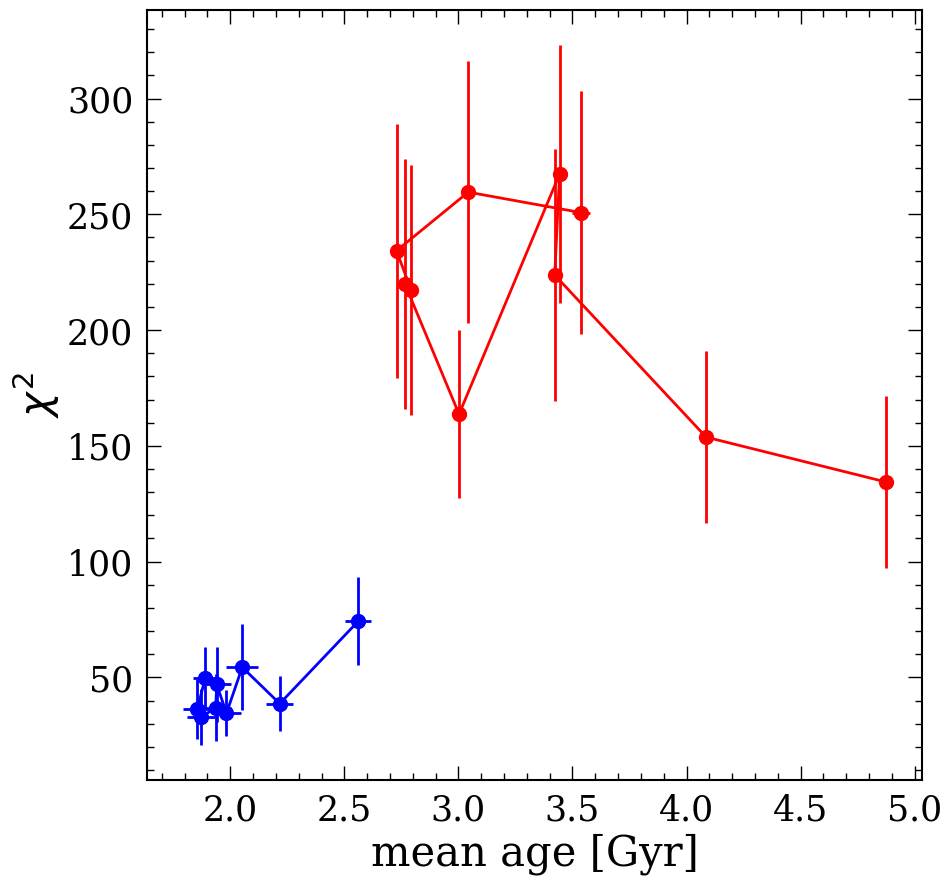

In [18]:


plt.figure()
plt.errorbar(ageinn, chi2inn, xerr=ageinn_err, yerr=chi2inn_err,fmt='r-o',
            markersize=10)
plt.errorbar(ageout, chi2out, xerr=ageout_err, yerr=chi2out_err,fmt='b-o',
            markersize=10)
plt.xlabel('mean age [Gyr]')
plt.ylabel('$χ^2$')


